In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pip install -q torchvision pandas
# %matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [3]:
from charts.common.dataset import LabeledImage
from charts.common.timer import Timer
import charts.pytorch.similar_colors as samecolors
import charts.pytorch.drawing_segmentation as ds
from charts.pytorch.utils import Experiment

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

from torchvision.utils import make_grid
from torchvision.io import read_image
from torchvision.transforms import ToTensor, ToPILImage
from torchvision import transforms

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

import os
from pathlib import Path
import time

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
display(f"Use CUDA: {use_cuda}")

'Use CUDA: True'

In [29]:
preprocessor = ds.Preprocessor(device)

dataset = ds.DrawingSegmentationDataset(Path('../../generated/drawings'), preprocessor, max_length=8)
n_train = max(len(dataset) // 2, 1)
# n_val = len(dataset) - n_train
# train_dataset, val_dataset = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(42))
generator = torch.Generator().manual_seed(42)

train_indices = range(0, n_train)
val_indices = range(n_train, len(dataset))
train_sampler = SubsetRandomSampler(train_indices, generator=generator)
val_sampler = SubsetRandomSampler(val_indices, generator=generator)

train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=8)
val_dataloader = DataLoader(dataset, sampler=val_sampler, batch_size=8)

monitored_sample = dataset[0]
monitored_sample_inputs = torch.unsqueeze(monitored_sample[0], dim=0)
monitored_sample_json = monitored_sample[2]

In [34]:
xp = Experiment("drawing_segmentation/2021-Dec16-Unet1", clear_previous_results=True)

net = ds.DrawSegmentation_Unet1()
net.to(device)

criterion = nn.CrossEntropyLoss()

# print (f"Initial training loss: {samecolors.compute_average_loss (train_dataloader, net, criterion)}")
# print (f"Initial validation loss: {samecolors.compute_average_loss (val_dataloader, net, criterion)}")

# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

xp.prepare (net, optimizer, device, monitored_sample_inputs)

for epoch in range(xp.first_epoch, 1000):  # loop over the dataset multiple times

    average_training_loss = 0.0
    tstart = time.time()
    
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels, json_files = data
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        batch_loss = loss.item()
        xp.writer.add_scalar("Single Batch Loss", batch_loss, epoch)

        average_training_loss += batch_loss

        try:
            idx = json_files.index(monitored_sample_json)
            # t.stop()
            
            # (2,H,W)
            output_for_idx = outputs[idx]
            # First apply softmax on the two classes.
            # Then take only channel 1 to get the softmax score for class 1.
            # Then unsqueeze it to add a channel dimension of 1 to please the writer.
            softmax_output_for_class1 = torch.softmax(output_for_idx, dim=0)[1].unsqueeze(0)

            xp.writer.add_image("Sample output",softmax_output_for_class1, epoch)
            xp.writer.add_image("Target output", labels[idx].unsqueeze(0), epoch)
            xp.writer.add_image("Sample input",  preprocessor.denormalize_and_clip_as_tensor(inputs[idx]), epoch)
        except ValueError: # monitored_json not in the batch
            pass
    
    average_training_loss = average_training_loss / len(train_dataloader)
    xp.writer.add_scalar("Average Training Loss", average_training_loss, epoch)

    average_val_loss = samecolors.compute_average_loss (val_dataloader, net, criterion)
    xp.writer.add_scalar("Average Validation Loss", average_val_loss, epoch)

    elapsedSecs = (time.time() - tstart)
    xp.writer.add_scalar("Elapsed Time (s)", elapsedSecs, epoch)
    print(f"[{epoch}] [TRAIN_LOSS={average_training_loss:.4f}] [VAL_LOSS={average_val_loss:.4f}] [{elapsedSecs:.1f}s]")

    if epoch % 10 == 1:
        xp.save_checkpoint(epoch)

print('Finished Training!')

Will store the experiment data to /home/nb/Perso/DaltonLensPrivate/charts/pytorch/experiments/drawing_segmentation/2021-Dec16-Unet1


AssertionError: size of input tensor and input format are different.         tensor shape: (256, 256), input_format: CHW

In [ ]:
def load_specific_checkpoint (name):
    checkpoint = torch.load(xp.log_path / name, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# load_specific_checkpoint ("checkpoint-00701.pt")
# torch.save (net, "regression_unet_v1.pt")

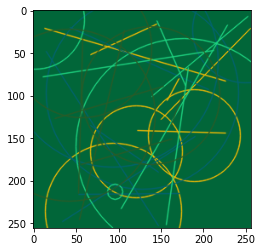

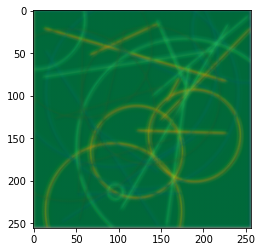

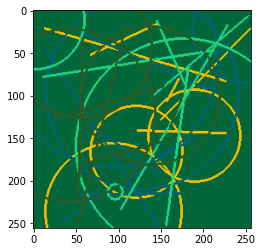

In [ ]:
with torch.no_grad():
    input, labels, _ = next(iter(train_dataloader))
    output = net(input)
    #clear_output(wait=True)
    plt.figure()
    plt.imshow (preprocessor.denormalize_and_clip_as_numpy(input[0]))
    plt.figure()
    plt.imshow (preprocessor.denormalize_and_clip_as_numpy(output[0]))
    plt.figure()
    plt.imshow (preprocessor.denormalize_and_clip_as_numpy(labels[0]))